In [1]:
import platform
from pathlib import Path

import os
import subprocess
import time

import numpy as np
import scipy
from scipy import optimize
import pandas as pd # I added as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from addict import Dict
import json

# Temporary files for simulation objects
import tempfile
tempfile.tempdir = os.path.join(Path.home())

# IPython
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image
from ipywidgets import interact, interactive
import ipywidgets as widgets

import copy
from biopandas.pdb import PandasPdb


# Depth of charged atoms in protein structures

In [7]:
prot_folders = os.listdir('pqr_structure_files')
prot_folders.sort()
prot_folders.remove('edtsurf_notes.txt')

In [8]:
dfs_pqr = {} # .pqr file (protein structure)
dfs_dep = {} # Depths of each atom in the pqr file beneath the VdW surface
dfs_sph_pqr = {} # Discrete charges from .pqr file projected onto sphere
                 # (i.e. nonzero charges as summed for each residue)

for f in prot_folders:
    if f[:3] == 'lys':
        pass
    else:
        # In this format, BioPandas loads the partial charge into the occupancy column
        dfs_pqr[f] = PandasPdb().read_pdb('./pqr_structure_files/' + f + '/pqr.pqr')
        dfs_dep[f] = pd.read_fwf('./pqr_structure_files/' + f + '/pqr_atom.dep')
        dfs_sph_pqr[f] = pd.read_csv('ns_bim_spherical_pqr/charges/' + f + '/pqr_charges.csv')

In [13]:
charged_ox = ['OXT', 'OE1', 'OE2', 'OD1', 'OD2'] # 'SG'
dfs_negative_atoms = {}

for f in prot_folders:
    if f[:3] == 'lys':
        pass
    else:
    
        temp = []
        i_ind = 0
        df = dfs_pqr[f].df['ATOM'].copy()
        
        for j, jcont in dfs_sph_pqr[f].iterrows():
            if jcont['q'] == -1.0:
                for i, icont in df.iloc[i_ind:].iterrows():
                    if jcont['res_num'] == icont['residue_number'] and icont['atom_name'] in charged_ox:
                        temp.append([icont['residue_name'], icont['atom_number'], icont['atom_name'], jcont['q'],])
                        i_ind = i
                        # This only picks out one of the two O atoms
                        break
        
        df_negative_atoms = pd.DataFrame(temp, columns=['res_name', 'atom_num', 'atom_name', 'q'])
        
        # Some terminal residues have +1 and -1 charges and weren't included in the 
        # file of .pqr charge spherical projections; this catches them
        for i, icont in df.iterrows():
            if icont['atom_name'] == 'OXT' and \
            icont['atom_number'] not in list(df_negative_atoms['atom_num']):
                df_negative_atoms.loc[len(df_negative_atoms)] = [icont['residue_name'], 
                icont['atom_number'], icont['atom_name'], jcont['q']]
            
        dfs_negative_atoms[f] = df_negative_atoms
        print(df_negative_atoms.tail(), '\n')

    res_name  atom_num atom_name    q
140      ASP     20668       OD1 -1.0
141      LYS      5140       OXT  2.0
142      LYS     10344       OXT  2.0
143      LYS     15504       OXT  2.0
144      LYS     20708       OXT  2.0 

   res_name  atom_num atom_name    q
49      GLU      4532       OE1 -1.0
50      ASP      4588       OD1 -1.0
51      GLU      4922       OE1 -1.0
52      GLU      4937       OE1 -1.0
53      CYS      4969       OXT -1.0 

    res_name  atom_num atom_name    q
222      ASP     31511       OD1 -1.0
223      GLU      7859       OXT  2.0
224      GLU     15767       OXT  2.0
225      GLU     23673       OXT  2.0
226      GLU     31583       OXT  2.0 

   res_name  atom_num atom_name    q
37      GLU      5391       OE1 -1.0
38      ASP      5438       OD1 -1.0
39      GLU      5509       OE1 -1.0
40      ASP      5592       OD1 -1.0
41      PRO      5975       OXT -1.0 



In [14]:
# Check the C terminii were appropriately included
for f in prot_folders:
    if f[:3] != 'lys':
        print(list(dfs_negative_atoms[f]['atom_name']).count('OXT'))

4
2
4
1


In [16]:
# Get depths of negatively charged atoms; note I believe 2.88 A means an O atom is on the surface
for f in prot_folders:
    if f[:3] != 'lys':
        for i, icont in dfs_negative_atoms[f].iterrows():
            dfs_negative_atoms[f].at[i, 'depth'] =\
            dfs_dep[f].loc[dfs_dep[f]['atom#'] == icont['atom_num'], 'depth'].iloc[0]

In [17]:
# Check appropriate charges have been identified; note I'm intentionally not including 
# S- charges here, which explains the discrepancy
for f in prot_folders:
    if f[:3] != 'lys':
        print(len(dfs_negative_atoms[f]), list(dfs_sph_pqr[f]['q']).count(-1.0))
        print(list(dfs_negative_atoms[f]['res_name']).count('ASP'), list(dfs_sph_pqr[f]['residue']).count('ASP'))
        print(list(dfs_negative_atoms[f]['res_name']).count('GLU'), list(dfs_sph_pqr[f]['residue']).count('GLU'))
        print(list(dfs_negative_atoms[f]['res_name']).count('CYS'), list(dfs_sph_pqr[f]['residue']).count('CYS'))
        print()


145 149
62 62
79 79
0 8

54 54
20 20
32 32
2 2

227 223
134 134
93 93
0 0

42 42
13 13
28 28
0 0



In [18]:
dfs_negative_atoms[f]

,res_name,atom_num,atom_name,q,depth
0,GLU,103,OE1,-1.0,2.880
1,ASP,168,OD1,-1.0,2.880
2,GLU,239,OE1,-1.0,2.880
3,GLU,369,OE1,-1.0,2.880
4,ASP,709,OD1,-1.0,2.880
5,ASP,932,OD1,-1.0,2.880
6,ASP,1286,OD1,-1.0,2.880
7,ASP,1450,OD1,-1.0,2.880
8,GLU,1656,OE1,-1.0,2.880
9,GLU,1671,OE1,-1.0,2.880


## Cumulative negative charge vs. depth

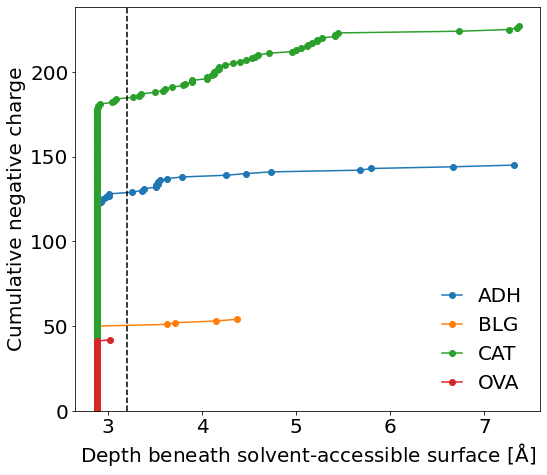

In [25]:
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(8, 7, forward=True)
fig.patch.set_alpha(1.0)
ax.set_xlabel(r'Depth beneath solvent-accessible surface [$\rm{\AA}$]')
ax.set_ylabel('Cumulative negative charge')

num_surf = []
total_neg = []
x_thresh = 3.2

for f in prot_folders:
    if f[:3] != 'lys':
        depths = list(dfs_negative_atoms[f]['depth'])
        depths.sort()
        threshold = next((x for x in depths if x > x_thresh), depths[-1])
        num_surf.append(depths.index(threshold) + 1)
        total_neg.append(len(depths))
        
        p = np.arange(len(depths)) + 1.0
        ax.plot(depths, p, linestyle='-', marker='o', label=f[:3].upper())

ax.axvline(x=x_thresh, linestyle='--', color='black')
ax.legend(handlelength=1, frameon=False)
plt.tight_layout()

ax.set_ylim(0, None)
fig.savefig('./images/protein_characteristics/cumulative_negative_charge_vs_depth.png', bbox_inches='tight', dpi=300)
fig.savefig('./images/protein_characteristics/cumulative_negative_charge_vs_depth.pdf', bbox_inches='tight')

In [9]:
num_surf

[129, 51, 185, 42]

In [10]:
masses = [147.3968*4/4, 36.8*2/2, 59.915*4, 42.7]
areas = [49082.671, 13391.213, 65641.059, 14841.587] # From EDTSurf output

# More general identification of buried charges
- And preparation of files for input to DH-NSBIM
- Note: ligands were not included when generating charge states with pdb2pqr
- Which means the Fe, Zn, and heme groups aren't accounted for rigorously - see approximate accounting (just using metal atom charges) below

## Load and pair depths with .pdb and .pqr data

In [2]:
prot_folders = os.listdir('pqr_structure_files')
prot_folders.sort()
# prot_folders = [i for i in prot_folders if 'lys' not in i]
prot_folders

['adh_pH_7',
 'blg_pH_7',
 'cat_pH_7',
 'lys_pH_5',
 'lys_pH_7',
 'lys_pH_9',
 'ova_pH_7']

In [3]:
dfs_pdb = {}
dfs_pdb_dep = {} # Depths of each atom in the .pdb file beneath the VdW surface
dfs_pqr = {} # .pqr file (protein structure) -- note that in this format, BioPandas 
             # loads the partial charge into the occupancy column
dfs_pqr_dep = {} # Depths of each atom in the .pqr file beneath the VdW surface

for f in prot_folders:
    pdb_path = f'./pdb_structure_files/{f}/'
    pdb_file = pdb_path + [i for i in os.listdir(pdb_path) if '.pdb' in i][0]
    dep_file = pdb_path + [i for i in os.listdir(pdb_path) if '_atom.dep' in i][0]
    dfs_pdb[f]     = PandasPdb().read_pdb(pdb_file)
    dfs_pdb_dep[f] = pd.read_fwf(dep_file)
    
    pqr_path = f'./pqr_structure_files/{f}/'
    pqr_file = pqr_path + [i for i in os.listdir(pqr_path) if '.pqr' in i][0]
    dep_file = pqr_path + [i for i in os.listdir(pqr_path) if '_atom.dep' in i][0]
    dfs_pqr[f]     = PandasPdb().read_pdb(pqr_file)
    dfs_pqr_dep[f] = pd.read_fwf(dep_file)

In [4]:
for f in prot_folders:
    for i, icont in dfs_pdb[f].df['ATOM'].iterrows():
        df_dep = dfs_pdb_dep[f]
        depth = df_dep.loc[df_dep['atom#']==icont.atom_number, 'depth'].iloc[0]
        dfs_pdb[f].df['ATOM'].at[i, 'depth'] = depth

    for i, icont in dfs_pdb[f].df['HETATM'].iterrows():
        df_dep = dfs_pdb_dep[f]
        depth = df_dep.loc[df_dep['atom#']==icont.atom_number, 'depth'].iloc[0]
        dfs_pdb[f].df['HETATM'].at[i, 'depth'] = depth
        
    for i, icont in dfs_pqr[f].df['ATOM'].iterrows():
        df_dep = dfs_pqr_dep[f]
        depth = df_dep.loc[df_dep['atom#']==icont.atom_number, 'depth'].iloc[0]
        dfs_pqr[f].df['ATOM'].at[i, 'depth'] = depth

    for i, icont in dfs_pqr[f].df['HETATM'].iterrows():
        df_dep = dfs_pqr_dep[f]
        depth = df_dep.loc[df_dep['atom#']==icont.atom_number, 'depth'].iloc[0]
        dfs_pqr[f].df['HETATM'].at[i, 'depth'] = depth

## Manually add Zn and Fe groups

In [5]:
f = 'adh_pH_7'
df = dfs_pdb[f].df['HETATM'].copy()
df = df[df.atom_name=='ZN']
df.occupancy = 2.0
dfs_pqr[f].df['ATOM'] = pd.concat([dfs_pqr[f].df['ATOM'], df], ignore_index=True)
dfs_pqr[f].df['ATOM']

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx,depth
0,ATOM,1,,N,,SER,,,1,,...,-22.707,58.098,-0.32,NaN,000,,,NaN,141,3.030
1,ATOM,2,,CA,,SER,,,1,,...,-21.907,58.620,0.33,NaN,000,,,NaN,142,3.300
2,ATOM,3,,C,,SER,,,1,,...,-21.426,57.445,0.55,NaN,000,,,NaN,143,3.280
3,ATOM,4,,O,,SER,,,1,,...,-22.127,57.039,-0.55,NaN,000,,,NaN,144,2.880
4,ATOM,5,,CB,,SER,,,1,,...,-20.748,59.487,0.00,NaN,000,,,NaN,145,3.360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20610,HETATM,5221,,ZN,,ZN,,B,402,,...,-5.089,56.165,2.00,37.70,,,ZN,NaN,10755,4.243
20611,HETATM,5167,,ZN,,ZN,,A,401,,...,13.891,80.893,2.00,33.11,,,ZN,NaN,21168,3.200
20612,HETATM,5168,,ZN,,ZN,,A,402,,...,-3.753,72.712,2.00,35.31,,,ZN,NaN,21169,4.542
20613,HETATM,5220,,ZN,,ZN,,B,401,,...,-14.121,82.049,2.00,49.56,,,ZN,NaN,21221,3.202


In [6]:
f = 'cat_pH_7'
df = dfs_pdb[f].df['HETATM'].copy()
df = df[df.atom_name=='FE']
df.occupancy = 2.0
dfs_pqr[f].df['ATOM'] = pd.concat([dfs_pqr[f].df['ATOM'], df], ignore_index=True)
dfs_pqr[f].df['ATOM']

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx,depth
0,ATOM,1,,N,,ASN,,,3,,...,11.890,2.002,-0.32,NaN,000,,,NaN,205,3.03
1,ATOM,2,,CA,,ASN,,,3,,...,12.407,3.393,0.33,NaN,000,,,NaN,206,3.30
2,ATOM,3,,C,,ASN,,,3,,...,13.935,3.357,0.55,NaN,000,,,NaN,207,3.28
3,ATOM,4,,O,,ASN,,,3,,...,14.599,2.386,-0.55,NaN,000,,,NaN,208,2.88
4,ATOM,5,,CB,,ASN,,,3,,...,12.038,4.244,0.00,NaN,000,,,NaN,209,3.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31459,ATOM,31589,,HB2,,GLU,,,501,,...,16.061,-8.111,0.00,NaN,000,,,NaN,31667,2.60
31460,HETATM,16073,,FE,,HEM,,A,2000,,...,42.462,29.012,2.00,29.46,,,FE,NaN,17135,3.20
31461,HETATM,16116,,FE,,HEM,,B,2001,,...,39.976,59.926,2.00,40.34,,,FE,NaN,17178,3.20
31462,HETATM,16159,,FE,,HEM,,C,2002,,...,9.237,54.712,2.00,33.85,,,FE,NaN,17221,3.20


## Identify locations of discrete charges

In [7]:
# for f in prot_folders:
#     df = dfs_pqr[f].df['ATOM']  
#     combos = zip(df.residue_number, df.my_residue_number)
#     unique = list(set(combos))
#     unique.sort()
#     df_unique = pd.DataFrame(unique, columns=['residue_number', 'my_residue_number'])
#     print(list(df_unique['residue_number']).count(df_unique.at[0, 'residue_number']))

In [8]:
# Assign unique sequential residue numbers 
for f in prot_folders:
    df = dfs_pqr[f].df['ATOM']
    residue_number = -1    
    
    my_residue_number = 0
    for i, icont in df.iterrows():
        if icont.residue_number != residue_number:
            my_residue_number += 1
            residue_number = icont.residue_number
        df.at[i, 'my_residue_number'] = my_residue_number

In [9]:
charge_locs = {
    'ASP':('OD1', 'OD2'),
    'GLU':('OE1', 'OE2'),
    'LYS':('NZ',),
    'ARG':('NH1', 'NH2',),
    'HIS':('ND1', 'NE1',)    
}

In [10]:
def add_charge_num(df, df_atom, cnt):
    df.loc[df_atom.index, 'charge_bearer_num'] = cnt
    cnt += 1
    return df, df_atom, cnt

def enumerate_std_charge(res_name, df_res, df, cnt):
    atoms = charge_locs[res_name]
    df_atom = pd.DataFrame()
    for atom_name in atoms:
        df_atom = pd.concat([df_atom, df_res[df_res.atom_name==atom_name]])
    df, df_atom, cnt = add_charge_num(df, df_atom, cnt)
    return df, df_atom, cnt

In [11]:
import sys

In [12]:
for f in prot_folders:
    df = dfs_pqr[f].df['ATOM']
    df['charge_bearer_num'] = 0.0               # All atoms are false until marked true
    n_term_res_num = min(df.residue_number) # I checked this was the same for each monomer

    my_residue_numbers = list(set(df.my_residue_number))
    
    cnt = 0
    for res_num in my_residue_numbers:
        df_res = df[df.my_residue_number==res_num]
        res_name = list(set(df_res.residue_name))[0]
        q = round(df_res.occupancy.sum())    # Some charges don't quite add up to an integer in the .pqr file
        df.loc[df_res.index, 'discrete_charge'] = q
        
        if q != 0:            
            if list(set(df_res.residue_number))[0] == n_term_res_num:
                df_atom = df_res[df_res.atom_name=='N']
                df, df_atom, cnt = add_charge_num(df, df_atom, cnt)
            elif 'OXT' in list(df_res.atom_name):
                df_atom = df_res[df_res.atom_name=='OXT']
                df, df_atom, cnt = add_charge_num(df, df_atom, cnt)

            if res_name in charge_locs:
                df, df_atom, cnt = enumerate_std_charge(res_name, df_res, df, cnt)
            elif list(set(df_res.atom_name))[0] == 'ZN' or list(set(df_res.atom_name))[0] == 'FE':
                df, df_atom, cnt = add_charge_num(df, df_res, cnt)
            elif list(set(df_res.residue_name))[0] == 'CYS':
                pass # Cys residues are excluded from bearing charge
        else:
            try:
                if 'OXT' in list(df_res.atom_name):
                    df, df_atom, cnt = enumerate_std_charge(res_name, df_res, df, cnt)
                    df.loc[df_atom.index, 'discrete_charge'] = 1.0
                    df_atom = df_res[df_res.atom_name=='OXT']
                    df, df_atom, cnt = add_charge_num(df, df_atom, cnt)
                    df.loc[df_atom.index, 'discrete_charge'] = -1.0
                elif list(set(df_res.residue_number))[0] == n_term_res_num:
                    df, df_atom, cnt = enumerate_std_charge(res_name, df_res, df, cnt)
                    df.loc[df_atom.index, 'discrete_charge'] = -1.0
                    df_atom = df_res[df_res.atom_name=='N']
                    df, df_atom, cnt = add_charge_num(df, df_atom, cnt)
                    df.loc[df_atom.index, 'discrete_charge'] = 1.0
            except KeyError as error:
    #             error = sys.exc_info()[0]
                print(error)
                print(f, q, set(df_res.residue_number), set(df_res.charge_bearer_num), list(set(df_res.residue_number))[0] == n_term_res_num)

            
#             else:
#                 print('Not included:  ', f, list(set(df_res.residue_name))[0], list(set(df_res.residue_number))[0], list(set(df_res.my_residue_number))[0], q)
#                 # There is uncertainty with respect to the identity of residue 87 in ovalbumin; for this reason, I'm not including it
#                 # pdb2pqr also predicts tyrosine is charged; I'm not including this either


'GLY'
ova_pH_7 0.0 {24} {0.0} True


# Identify average charge locations 
(for residues where the charge exists in isomeric states)

In [13]:
dfs_points = {}

for f in prot_folders:
    df = dfs_pqr[f].df['ATOM']
    bearer_nums = list(set(df.charge_bearer_num))
    temp = []

    for num in bearer_nums:
        df_charge = df[df.charge_bearer_num==num]
        index     = df_charge.index[0]
        res_num   = df_charge.at[index, 'my_residue_number']
        res_name  = df_charge.at[index, 'residue_name']
        q         = df_charge.at[index, 'discrete_charge']
        depth     = df_charge.at[index, 'depth']
        x         = df_charge.x_coord.mean()
        y         = df_charge.y_coord.mean()
        z         = df_charge.z_coord.mean()
        temp.append([res_name, res_num, x, y, z, q, depth])

    dfs_points[f] = pd.DataFrame(temp, columns=['residue', 'res_num', 'x', 'y', 'z', 'q', 'depth']) 
    

### Make spherical projections


In [14]:
q_radii = {'adh_pH_7':3.4223,
           'blg_pH_7':2.0690,
           'cat_pH_7':3.9209,
           'lys_pH_5':1.4380,
           'lys_pH_7':1.4380,
           'lys_pH_9':1.4380,
           'ova_pH_7':2.1883}

In [15]:
for f in prot_folders:
    df = dfs_pqr[f].df['ATOM']
    df_pts = dfs_points[f]
    (x_cent, y_cent, z_cent) = (df.x_coord.mean(), df.y_coord.mean(), df.z_coord.mean())
    
    df_pts.x -= x_cent
    df_pts.y -= y_cent
    df_pts.z -= z_cent
    
    df_pts['radii_original'] = np.sqrt(df_pts.x**2 + df_pts.y**2 + df_pts.z**2)
    q_radius = q_radii[f]
    
    df_pts.x *= q_radius/df_pts['radii_original']
    df_pts.y *= q_radius/df_pts['radii_original']
    df_pts.z *= q_radius/df_pts['radii_original']
    df_pts['radius_new'] = np.sqrt(df_pts.x**2 + df_pts.y**2 + df_pts.z**2)

### Select surface charges

In [17]:
depth_cut = 3.2

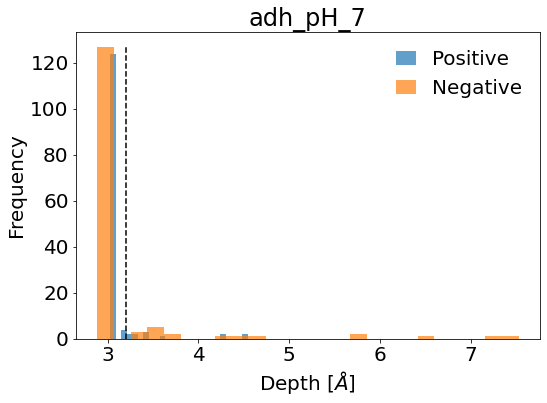

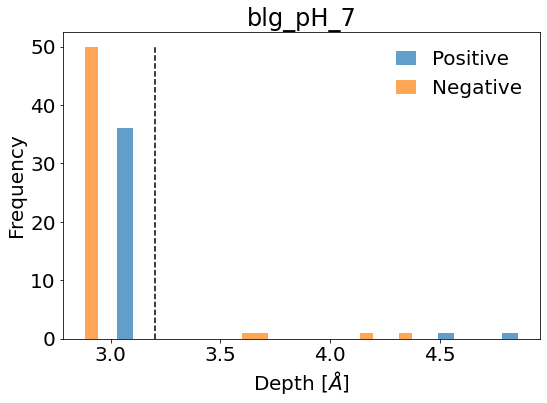

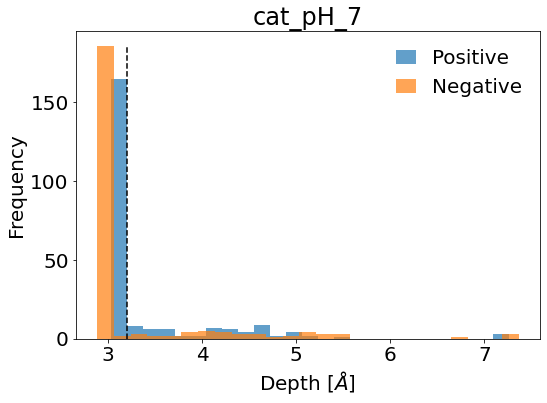

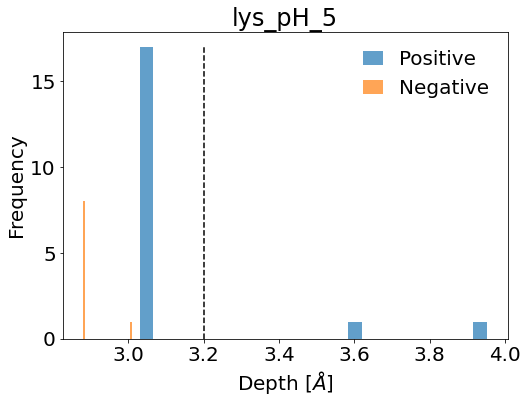

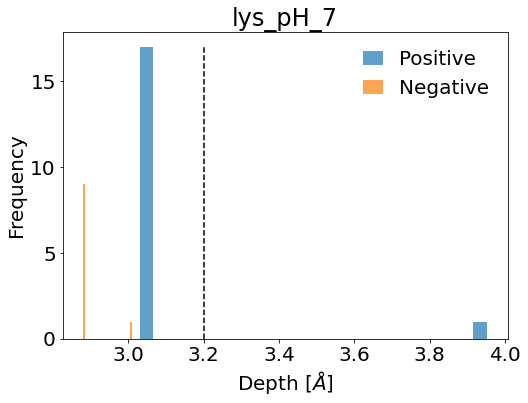

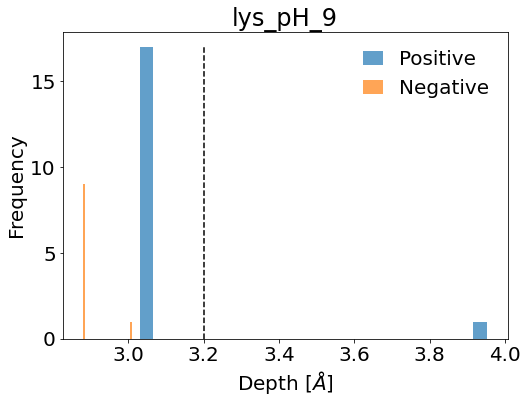

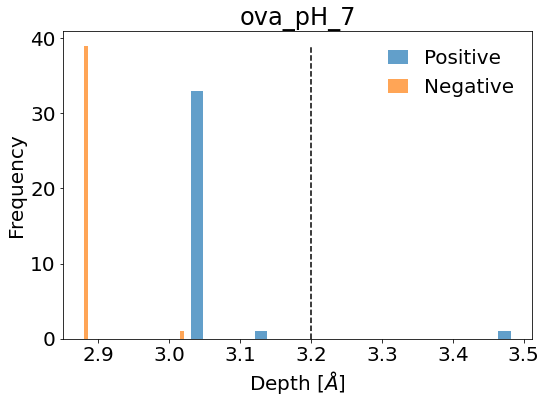

In [28]:
alpha = 0.7
bins = 25

for f in prot_folders:
    df_pts = dfs_points[f]
    
    params = {'font.weight':'normal', 'font.size':20}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    fig.patch.set_alpha(1.0)
    ax.set_xlabel(r'Depth [$\AA$]')
    ax.set_ylabel('Frequency')
    ax.set_title(f)

    df = df_pts[df_pts.q > 0]
    h1 = ax.hist(df.depth, bins=bins, alpha=alpha, label='Positive')
    
    df = df_pts[df_pts.q < 0]
    h2 = ax.hist(df.depth, bins=bins, alpha=alpha, label='Negative')
    
    ax.legend(loc='upper right', frameon=False, handlelength=1.0)
    
    ax.vlines(3.2, 0, max(max(h1[0]), max(h2[0])), color='black', linestyle='dashed')
    plt.tight_layout()
    fig.savefig(f'./images/depth_histogram_images/{f}.png', dpi=300)

In [411]:
for f in prot_folders:
    df_pts = dfs_points[f]
    df_to_save = df_pts[df_pts.depth < depth_cut].copy()
    df_to_save.drop(columns=['depth', 'radii_original', 'radius_new'], inplace=True)
    new_dir = f'./ns_bim_spherical_pqr/new_inputs_surface_charges/{f}/'
    try:
        os.mkdir(new_dir)
    except:
        pass
    df_to_save.to_csv(new_dir + 'pqr_charges_surface.csv', index=False)